# 第九章: On-policy Prediction with Approximation （基于函数逼近的同轨策略预测）

## 背景与动机

### 表格方法的局限
- 前几章（如第6章TD学习、第8章Dyna）的算法假设状态和动作空间是离散且有限的，使用表格存储价值 $V(s)$ 或 $Q(s, a)$。
- 在现实任务中（如机器人控制、游戏），状态空间可能很大或连续，表格方法内存需求爆炸，无法泛化。

### 函数逼近的引入
- 用参数化函数（如线性函数或神经网络）近似价值函数：$\hat{V}(s, \mathbf{w}) \approx V^\pi(s)$，其中 $\mathbf{w}$ 是参数向量。
- 目标：通过调整 $\mathbf{w}$ 使近似价值逼近真实价值。

### 在线策略预测
- 本章聚焦评估给定策略 $\pi$ 的价值函数 $V^\pi(s)$，即预测问题，而非控制（优化策略）。

## 函数逼近的基本框架

### 形式
- 价值函数近似为 $\hat{V}(s, \mathbf{w})$，例如：
  - 线性逼近：$\hat{V}(s, \mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s)$，其中 $\mathbf{x}(s)$ 是状态 $s$ 的特征向量（有时也用 $ϕ(s)$ 来表示）。
  - 非线性逼近：如神经网络，$\hat{V}(s, \mathbf{w}) = f(s, \mathbf{w})$。

### 特征提取
- $\mathbf{x}(s)$ 将状态映射到特征空间。
- 特征设计影响逼近能力。

### 目标
- 最小化近似价值与真实价值的误差，通常用均方误差（MSE）：

$$J(\mathbf{w}) = \mathbb{E}_\pi[(V^\pi(s) - \hat{V}(s, \mathbf{w}))^2]$$

## 梯度下降优化

### 问题
- 真实价值 $V^\pi(s)$ 未知，无法直接计算 $J(\mathbf{w})$。

### 随机梯度下降（SGD）
- 用样本估计梯度，逐步更新参数：

$$\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla_{\mathbf{w}} J(\mathbf{w})$$

- 对于单样本，目标是使 $\hat{V}(s, \mathbf{w})$ 接近某个"目标值"（target）。

### TD目标
- 用TD(0)的目标 $R_{t+1} + \gamma \hat{V}(s_{t+1}, \mathbf{w})$ 代替 $V^\pi(s_t)$。
- 损失函数（单步误差）：

$$J_t(\mathbf{w}) = \frac{1}{2} [R_{t+1} + \gamma \hat{V}(s_{t+1}, \mathbf{w}) - \hat{V}(s_t, \mathbf{w})]^2$$

- 梯度：

$$\nabla_{\mathbf{w}} J_t(\mathbf{w}) = [R_{t+1} + \gamma \hat{V}(s_{t+1}, \mathbf{w}) - \hat{V}(s_t, \mathbf{w})] \nabla_{\mathbf{w}} \hat{V}(s_t, \mathbf{w})$$

_（这里是半梯度近似，忽略了 $\hat{V}(s_{t+1}, \mathbf{w})$ 的部分）_

## 线性TD(0)

### 线性逼近
- $\hat{V}(s, \mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s)$。
- 梯度 $\nabla_{\mathbf{w}} \hat{V}(s, \mathbf{w}) = \mathbf{x}(s)$。

_这里 $\mathbf{w}$ 是一个参数向量，$\mathbf{x}(s)$ 是一个特征向量，$\mathbf{w}^\top \mathbf{x}(s)$ 表示两者的内积（点积），是一个标量。_
_梯度 $\nabla_{\mathbf{w}} \hat{V}$ 是一个向量，其每个分量是对 $\hat{V}$ 关于 $\mathbf{w}$ 的每个分量求偏导数。_
_对线性函数求导时，导数就是这个参数的系数本身。_

### 更新规则
- $\mathbf{w} \leftarrow \mathbf{w} + \alpha [R_{t+1} + \gamma \mathbf{w}^\top \mathbf{x}(s_{t+1}) - \mathbf{w}^\top \mathbf{x}(s_t)] \mathbf{x}(s_t)$
- TD误差：$\delta_t = R_{t+1} + \gamma \mathbf{w}^\top \mathbf{x}(s_{t+1}) - \mathbf{w}^\top \mathbf{x}(s_t)$。

### 伪代码
```
初始化参数 w
重复（每个回合）：
    s ← 初始状态
    重复（每个时间步）：
        根据策略 π 选择动作 a
        执行 a，观察 r 和 s'
        δ ← r + γ w^T x(s') - w^T x(s)
        w ← w + α δ x(s)
        s ← s'
    直到 s 为终止状态
```

### 特点
- 线性方法计算简单，收敛性有理论保证。
- 依赖特征 $\mathbf{x}(s)$ 的质量。

## 收敛性分析

### 表格TD的收敛
- 第6章证明TD(0)在表格形式下收敛到 $V^\pi(s)$。

### 线性TD的收敛
- 在在线策略下，若特征矩阵和学习率满足条件（如特征线性无关，$\alpha$ 递减），线性TD(0)收敛到全局最优解。
- 收敛点可能是 $V^\pi(s)$ 的最佳线性近似，而非精确值。

### 非线性逼近
- 如神经网络，收敛性不再保证，可能陷入局部极值，但实践效果强大。

## 与蒙特卡洛的对比

### 蒙特卡洛逼近
- 用完整回报 $G_t$ 作为目标：

$$\mathbf{w} \leftarrow \mathbf{w} + \alpha [G_t - \hat{V}(s_t, \mathbf{w})] \nabla_{\mathbf{w}} \hat{V}(s_t, \mathbf{w})$$

- 无偏但方差高。

### TD逼近
- 用 $R_{t+1} + \gamma \hat{V}(s_{t+1}, \mathbf{w})$ 作为目标，方差低但有偏差。
- 在线更新，适合实时任务。

## 批量方法（Batch Methods）

### 问题
- 在线TD每次只用一个样本更新，可能效率不高。

### 最小二乘TD（LS-TD）
- 收集所有样本，求解全局最优 $\mathbf{w}$：

$$\mathbf{w} = \arg\min_{\mathbf{w}} \sum_t [R_{t+1} + \gamma \hat{V}(s_{t+1}, \mathbf{w}) - \hat{V}(s_t, \mathbf{w})]^2$$

- 适合小数据集，但计算复杂度高。

## 与前几章的联系

### 第6章（TD学习）
- 第9章将TD(0)从表格扩展到函数逼近，保留了自举特性。

### 第7章（n步自举）
- n步TD也可以结合逼近，如：

$$\mathbf{w} \leftarrow \mathbf{w} + \alpha [G_{t:t+n} - \hat{V}(s_t, \mathbf{w})] \nabla_{\mathbf{w}} \hat{V}(s_t, \mathbf{w})$$

### 第8章（规划与学习）
- 函数逼近为大规模问题下的规划提供了基础。

## 实践与扩展

### 示例
- 书中用"随机游走"展示了线性TD的收敛，特征可以是状态的简单编码。

### 扩展
- 第10章将讨论控制问题（如Q-learning的逼近）。
- 非线性逼近（如深度神经网络）在现代RL中更常见。

## 总结

第9章引入了函数逼近，将TD学习扩展到大规模问题，重点是在线策略预测。线性TD(0)通过梯度下降优化参数，保留了TD的自举特性，并在理论上保证收敛。非线性逼近（如神经网络）虽未深入讨论，但为现代深度强化学习（如DQN）铺路。第10章将进一步探讨控制问题。

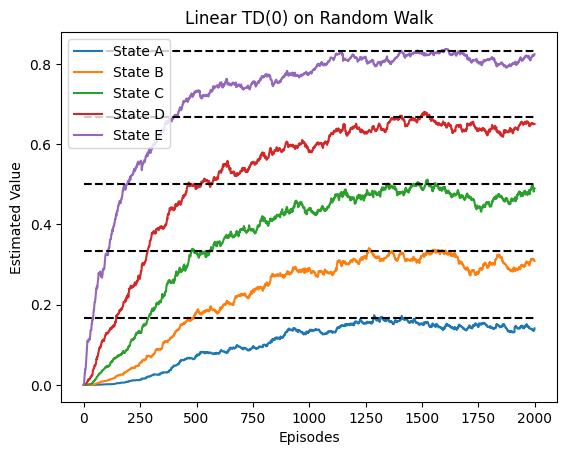

Final w: [0.14094983 0.30921277 0.48985862 0.65029681 0.82446518]
True Values: [0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334]


In [6]:
"""
以下是随机游走的线性TD(0)版本（Random Walk）：

实现方式：
- 使用参数向量w和特征函数features(s)实现函数逼近，值函数通过线性组合表示。而非之前章节的表格方法。
- 专注于评估策略(预测问题)
- 使用one-hot特征，线性TD(0)退化为表格TD，结果接近真实值。
"""
import numpy as np
import matplotlib.pyplot as plt

# 参数
n_states = 5  # A, B, C, D, E (1-5，忽略0和6的终止状态)
alpha = 0.01
gamma = 1.0
n_episodes = 2000

# 特征：简单one-hot编码
def features(s): return np.eye(n_states + 2)[s]  # 状态0和6为终止
w = np.zeros(n_states + 2)  # 参数向量
V_history = []

# TD(0)训练
np.random.seed(42)
for episode in range(n_episodes):
    state = 3  # 从C开始
    while True:
        action = np.random.choice([-1, 1])
        next_state = state + action
        if next_state == 0:  # A
            reward = 0
            w += alpha * (reward + gamma * w[next_state] - w[state]) * features(state)
            break
        elif next_state == n_states + 1:  # E
            reward = 1
            w += alpha * (reward + gamma * w[next_state] - w[state]) * features(state)
            break
        else:
            reward = 0
            w += alpha * (reward + gamma * w[next_state] - w[state]) * features(state)
            state = next_state
    V_history.append(w[1:n_states + 1].copy())

# 可视化
true_V = [1/6, 2/6, 3/6, 4/6, 5/6] # 真实值
plt.plot(np.array(V_history)[:, 0], label='State A')
plt.plot(np.array(V_history)[:, 1], label='State B')
plt.plot(np.array(V_history)[:, 2], label='State C')
plt.plot(np.array(V_history)[:, 3], label='State D')
plt.plot(np.array(V_history)[:, 4], label='State E')
plt.plot([0, n_episodes], [true_V[0]]*2, 'k--')
plt.plot([0, n_episodes], [true_V[1]]*2, 'k--')
plt.plot([0, n_episodes], [true_V[2]]*2, 'k--')
plt.plot([0, n_episodes], [true_V[3]]*2, 'k--')
plt.plot([0, n_episodes], [true_V[4]]*2, 'k--')
plt.xlabel('Episodes')
plt.ylabel('Estimated Value')
plt.legend()
plt.title('Linear TD(0) on Random Walk')
plt.show()

print("Final w:", w[1:n_states + 1])
print("True Values:", true_V)